# Imports

In [78]:
import requests
import json
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
from ipyleaflet import Map, Marker


from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

RUN_FROM = 'uni_wifi' #'bastion'

if RUN_FROM == 'bastion' : URL, HEADERS = 'http://fission:31001/', None
if RUN_FROM == 'uni_wifi': URL, HEADERS =  'http://172.26.135.52:9090/', {'HOST': 'fission'}

WEATHER_NUM_COL = ['UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain']

# Functions

In [2]:
def weather_to_pd(station_id: str, start_year: int, end_year: int, verb=False) -> pd.DataFrame:
    resp_dict = requests.get(URL+f'weather/{station_id}/{start_year}/{end_year}', headers=HEADERS).json()
    if verb : print(str(resp_dict)[:100])
    data = resp_dict['Data']
    if verb : print(f'Called weather api, fetched {len(data)} lines')
    return pd.DataFrame.from_records(data)

In [3]:
def get_stream_to_pd(api: str, station_id: str, size: int, radius_km: int, year=None, verb=False) -> pd.DataFrame:

    if year is None :
        resp_dict = requests.get(URL+api+f'/{station_id}/{size}/{radius_km}',
                                 headers=HEADERS).json()
    else :
        resp_dict = requests.get(URL+api+f'/{station_id}/{size}/{radius_km}',
                                 params=f'year={year}', headers=HEADERS).json()
    if verb : print(str(resp_dict)[:100])

    count=0
    status, token, new_data = resp_dict['Status'], resp_dict['Token'], resp_dict['Data']
    data = [new_data[i]['_source'] for i in range(len(new_data))]
    if verb : print(f'Called {api} api, fetched {len(new_data)} lines')


    while (status == 200) and (new_data != []) :
        count+=1
        resp_dict = json.loads(requests.get(URL+f'stream/'+token, headers=HEADERS).text)
        status, token, new_data = resp_dict['Status'], resp_dict['Token'], resp_dict['Data']
        if verb : print(f'Called stream {count} times, fetched {len(new_data)} new lines')
        data += [new_data[i]['_source'] for i in range(len(new_data))]

    if verb: print(f'Fetched a total of {len(data)}lines')
    return pd.DataFrame.from_records(data)

In [4]:
def clean_weather_pd(df_weather_full):
    df_weather = df_weather_full.copy()

    for col in WEATHER_NUM_COL:
        df_weather[col] = pd.to_numeric(df_weather[col])

    df_weather = df_weather.rename(columns={'Date':'date'})
    df_weather['date'] = pd.to_datetime(df_weather['date'], format='%d/%m/%Y').dt.date
    df_weather = df_weather.drop(columns=['created_at','source', 'Station Name'])

    return df_weather

In [5]:
def clean_crime_df(df_crime_full):
    df_crime = df_crime_full.groupby(['reported_date', 'description_1'])['offence_count'].sum().reset_index()

    df_crime = df_crime.rename(columns={'reported_date':'date'})
    df_crime['date'] = pd.to_datetime(df_crime['date']).dt.date

    return df_crime

In [6]:
def get_prediction_from_api(model_name, values):
    params = {'predictors': ','.join(map(str, values))}
    response = requests.get(URL+f'models/{model_name}', params=params)
    return response

In [ ]:
def get_live_weather(latitude, longitude):
    params = {'lat': latitude, 'lon': longitude}
    response = requests.get(URL+f'current-weather', params=params)
    return response

# Welcome to IISTGO

![title](img/isitsafe_banner.webp)

### Where do you live?

In [7]:
# Choose your position
center = (-38., 145.)
mm = Map(center=center, zoom=6)
marker = Marker(location=center, draggable=True)
mm.add(marker)
display(mm)

Map(center=[-38.0, 145.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [14]:
#Choose your radius for study
slider = widgets.FloatSlider(description='Radius in km', min=0, max=700)
slider.value = 50
widgets.VBox([slider])

In [58]:
# Summary of the study
LOCATION = marker.location
RADIUS = slider.value

resp = requests.get(URL+f'stations/{LOCATION[1]}/{LOCATION[0]}').json()
STATION_ID = resp['Data']['Station ID']

print(f'Chosen Coordinates: {LOCATION}')
print(f'Chosen study radius: {RADIUS} km')
print(f'Closest weather station name and ID: {resp["Data"]["Station Name"]} {STATION_ID}')
print(f'Study conducted over the last ten years')

Chosen Coordinates: [-37.6664292120906, 144.5579528185394]
Chosen study radius: 684.2 km
Closest weather station name and ID: Melbourne Airport 86282
Study conducted over the last ten years


### General trends over the last year

In [99]:
df_crime_full_y = get_stream_to_pd(api='crime', station_id=STATION_ID, size=8000, radius_km=RADIUS, year=2023, verb=True)

{'Status': 200, 'Token': 'FGluY2x1ZGVfY29udGV4dF91dWlkDnF1ZXJ5VGhlbkZldGNoBRZZZTYzQ1hPS1NYMnVYZDlMSV
Called crime api, fetched 8000 lines
Called stream 1 times, fetched 8000 new lines
Called stream 2 times, fetched 8000 new lines
Called stream 3 times, fetched 8000 new lines
Called stream 4 times, fetched 8000 new lines
Called stream 5 times, fetched 3861 new lines
Called stream 6 times, fetched 0 new lines
Fetched a total of 43861lines


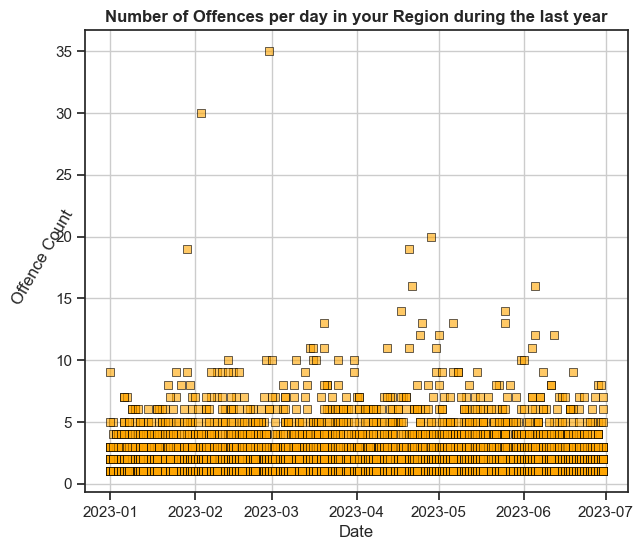

In [103]:
df_crime_full_y['reported_date'] = pd.to_datetime(df_crime_full_y['reported_date'],format="%Y-%m-%dT%H:%M:%S")

# Create the scatter plot with custom markers
ax = df_crime_full_y.plot.scatter('reported_date', # x-axis
                                  'offence_count', # y-axis
                                  figsize=(7,6),
                                  marker=',',  # Use circles as markers
                                  color='orange',  # Marker color
                                  edgecolor='black',  # Marker edge color
                                  s=40,  # Marker size
                                  alpha=0.6,  # Marker transparency
                                  linewidth=0.7, # Width of the edges
                                  grid=True
                                  )

# Add title and labels ('\n' allows us to jump rows)
ax.set_title('Number of Offences per day in your Region during the last year', weight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Offence Count', rotation=60)

# Show the plot
plt.show()

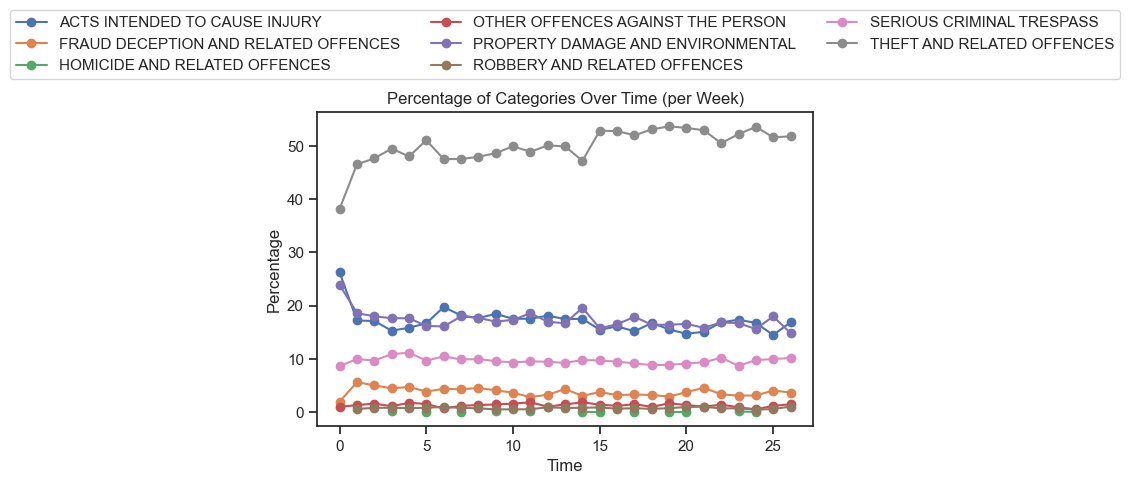

In [124]:
df_crime_full_y['description_2'].unique()

df_crime_full_y['week'] = df_crime_full_y['reported_date'].apply(lambda dt : dt.isocalendar().week%52)


# Calculate total values per time
total_per_week_cat = df_crime_full_y.groupby(['description_2','week'])['offence_count'].sum().reset_index()

total_per_week = total_per_week_cat.groupby(['week'])['offence_count'].sum().reset_index()
total_per_week = total_per_week.rename(columns={'offence_count':'offence_count_week'})

# Merge total values back to the original dataframe
total_per_week_cat = total_per_week_cat.merge(total_per_week, on='week')


# Calculate percentage
total_per_week_cat['percentage'] = total_per_week_cat['offence_count'] / total_per_week_cat['offence_count_week'] * 100

total_per_week_cat
# Pivot the dataframe for plotting
pivot_df = total_per_week_cat.pivot(index='week', columns='description_2', values='percentage')

# Plotting
ax = pivot_df.plot(kind='line', marker='o')
ax.set_title('Percentage of Categories Over Time (per Week)')
ax.set_xlabel('Time')
ax.set_ylabel('Percentage')
ax.legend(title='Category')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.35),ncol=3)
plt.show()

### Does Weather impacts Crimes in your area ?

In [22]:
# Fetching data and computing 
df_weather_full = weather_to_pd(station_id=STATION_ID, start_year=2014, end_year=2024, verb=True)
df_weather = clean_weather_pd(df_weather_full)
df_crime_full = get_stream_to_pd(api='crime', station_id=STATION_ID, size=8000, radius_km=RADIUS, verb=True)
df_crime = clean_crime_df(df_crime_full)
df = pd.merge(df_weather, df_crime, on='date', how='inner')

{'Status': 200, 'Data': [{'UV': '6.22', 'Max Humid': '91', 'created_at': '2024-05-17T00:41:37.845687
Called weather api, fetched 3648 lines
{'Status': 200, 'Token': 'FGluY2x1ZGVfY29udGV4dF91dWlkDnF1ZXJ5VGhlbkZldGNoBRZZZTYzQ1hPS1NYMnVYZDlMSV
Called crime api, fetched 8000 lines
Called stream 1 times, fetched 8000 new lines
Called stream 2 times, fetched 2292 new lines
Called stream 3 times, fetched 0 new lines
Fetched a total of 18292lines


#### For offences against persons

In [23]:
df_pers = df[df['description_1'] == 'OFFENCES AGAINST THE PERSON']
df_pers = df_pers.drop(columns=['description_1', 'date', 'state'])

lin_model_pers = LinearRegression()
lin_model_pers.fit(df_pers.drop(columns='offence_count').values, df_pers['offence_count'])
pd.DataFrame({'Predictors': df_pers.columns[:-1], 'Coefficient': lin_model_pers.coef_})

,Predictors,Coefficient
0,UV,0.014808
1,Max Humid,0.005914
2,Min Temp,0.000299
3,WindSpeed,0.007509
4,Min Humid,0.002541
5,Rain,-0.001798
6,Pan-Rain,0.003195
7,Max Temp,0.003976
8,Evapo-Rain,-0.011812


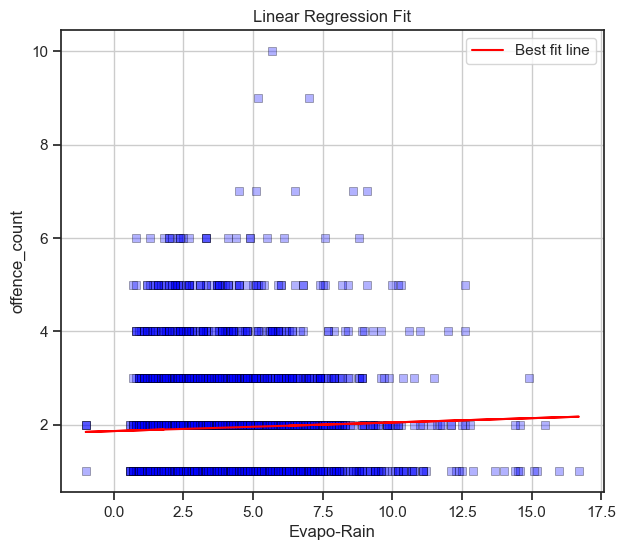

In [140]:
sub_lin_model_pers = LinearRegression()
sub_lin_model_pers.fit(df_pers[['Evapo-Rain']].values, df_pers['offence_count'])

Y_pred = sub_lin_model_pers.predict(df_pers[['Evapo-Rain']].values)

plt.close('all')

# Plotting the scatter plot
ax = df_pers.plot.scatter('Evapo-Rain', # x-axis
                                  'offence_count', # y-axis
                                  figsize=(7,6),
                                  marker=',',  # Use circles as markers
                                  color='blue',  # Marker color
                                  edgecolor='black',  # Marker edge color
                                  s=40,  # Marker size
                                  alpha=0.3,  # Marker transparency
                                  linewidth=0.7, # Width of the edges
                                  grid=True
                                  )

# Plotting the best-fitted line
ax.plot(df_pers['Evapo-Rain'], Y_pred, color='red', label='Best fit line')

# Adding labels and title
ax.set_xlabel('Evapo-Rain')
ax.set_ylabel('offence_count')
ax.set_title('Linear Regression Fit')
ax.legend()

# Display the plot
plt.show()

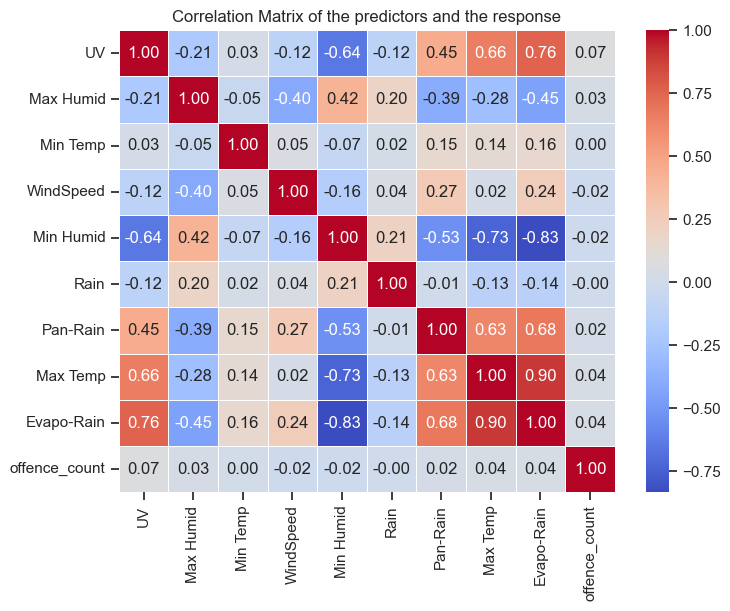

In [144]:
corr_table_pers = df_pers.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_table_pers, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of the predictors and the response')
plt.show()

In [145]:
predictor = 'Evapo-Rain'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(df_pers[predictor], df_pers['offence_count'])
print(f'With a correlation of {r},\nthe p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of 0.038327757188049434, the p-value associated to H0:"There is no correlation" is 0.058516077826552236


#### For offences against properties

In [146]:
df_prop = df[df['description_1'] == 'OFFENCES AGAINST PROPERTY']
df_prop = df_prop.drop(columns=['description_1', 'date', 'state'])

lin_model_prop = LinearRegression()
lin_model_prop.fit(df_prop.drop(columns='offence_count').values, df_prop['offence_count'])
pd.DataFrame({'Predictors': df_prop.columns[:-1], 'Coefficient': lin_model_prop.coef_})

,Predictors,Coefficient
0,UV,0.014452
1,Max Humid,-0.003636
2,Min Temp,-0.002408
3,WindSpeed,0.016097
4,Min Humid,0.010662
5,Rain,-0.004035
6,Pan-Rain,-0.017211
7,Max Temp,0.028531
8,Evapo-Rain,0.043360


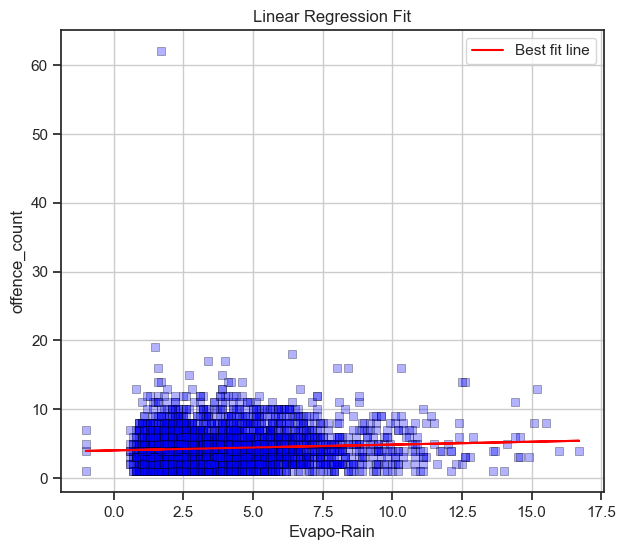

In [147]:
sub_lin_model_prop = LinearRegression()
sub_lin_model_prop.fit(df_prop[['Evapo-Rain']].values, df_prop['offence_count'])

Y_pred = sub_lin_model_prop.predict(df_prop[['Evapo-Rain']].values)

plt.close('all')

# Plotting the scatter plot
ax = df_prop.plot.scatter('Evapo-Rain', # x-axis
                                  'offence_count', # y-axis
                                  figsize=(7,6),
                                  marker=',',  # Use circles as markers
                                  color='blue',  # Marker color
                                  edgecolor='black',  # Marker edge color
                                  s=40,  # Marker size
                                  alpha=0.3,  # Marker transparency
                                  linewidth=0.7, # Width of the edges
                                  grid=True
                                  )

# Plotting the best-fitted line
ax.plot(df_prop['Evapo-Rain'], Y_pred, color='red', label='Best fit line')

# Adding labels and title
ax.set_xlabel('Evapo-Rain')
ax.set_ylabel('offence_count')
ax.set_title('Linear Regression Fit')
ax.legend()

# Display the plot
plt.show()

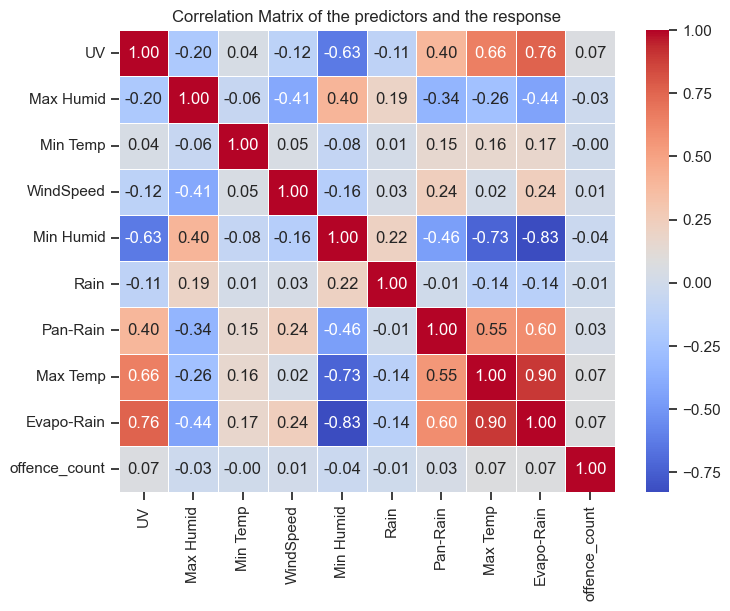

In [148]:
corr_table_prop = df_prop.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_table_prop, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of the predictors and the response')
plt.show()

In [150]:
predictor = 'Evapo-Rain'  # 'UV', 'Min Temp', 'Max Temp', 'WindSpeed', 'Min Humid', 'Max Humid', 'Rain', 'Pan-Rain', 'Evapo-Rain'
r, p_value = pearsonr(df_prop[predictor], df_prop['offence_count'])
print(f'With a correlation of {r},\nthe p-value associated to H0:"There is no correlation" is {p_value}')

With a correlation of 0.07294463289740696,
the p-value associated to H0:"There is no correlation" is 2.565564951179508e-05


### Get predictions 

In [46]:
live_values_all = get_live_weather(LOCATION[0],LOCATION[1]).json()
live_values = {measure : live_values_all['Data'][measure] 
               for measure in ['Wind Speed (km/h)','Temp','Humid','Rain']}

Predicted number of offences against persons today in the State of Victoria

In [152]:
# Get predictions
values = [30.0, live_values['Temp'],live_values['Temp'], live_values['Wind Speed (km/h)'],
          live_values['Humid'], live_values['Humid'], live_values['Rain'], 7.0, 6.0]
response = get_prediction_from_api('lin_model_crime_pers_VIC', values).json()
print(f"The predicted number of offences today in the state of Victoria is {response['prediction']}")

The predicted number of offences today in the state of Victoria is 2.173547382459704
